#Importación de Librerias y Funciones Base

In [0]:
#En este bloque se importa todo lo necesario para la ejecución de operaciones relacionadas al proyecto.

#Se utiliza:
#OpenCV 2
#Funcionalidades del Sistema Operativo (OS)
#Funciones y parametros especificos del sistema (SYS)
#Numpy
#Pandas
#Matplotlib
#ipywidgets
#scikit-learn

#Cada celda tendrá un %%time, el cual nos ayudara a ver el tiempo de ejecución de esta, y asi poder predecir a futuro que tareas
#requieren más recursos/son más intensivas.

import os
import sys
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as skl
import scipy as sp
import gc

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import (match_descriptors, corner_harris, corner_peaks, ORB, plot_matches)

print('OpenCV: ', cv.__version__)
print('NumPy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('SKlearn: ', skl.__version__)
print('Matplotlib: ', mpl.__version__)
print('SciPy: ', sp.__version__)
print('Python: ', sys.version)

%matplotlib inline

OpenCV:  3.4.3
NumPy:  1.16.4
Pandas:  0.24.2
SKlearn:  0.21.2
Matplotlib:  3.0.3
SciPy:  1.3.0
Python:  3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [0]:
from google.colab import drive #solo para colaboratory
drive.mount('/content/gdrive/') #solo para colaboratory

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#En este bloque definimos una función que nos permite observar el progreso iterativo de ciclos en jupyter, usando python
#Fuente: https://github.com/kuk/log-progress

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues , prnt_cm = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if prnt_cm:
            print("Normalized confusion matrix")
            print(cm)
    else:
        if prnt_cm:
            print('Confusion matrix, without normalization')
            print(cm)
       

    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, fraction=0.046, pad=0.04)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [0]:
#En este bloque se extrae la información del dataset, el cual no es un dataset común de datos en texto, sino un grupo de
#imagenes organizado por carpetas, y cada carpeta está nombrada por su respectiva clase.

#Luego de extraer la información se manipula con filtros, especificamente: blur gaussiano, segmentación de otsu, y
#redimensionamiento. Luego se procede a dividir lo extraido en dos grupos, uno de entrenamiento con el 80%, y otro de prueba
#con el 20%.

#Por último, debido a limitaciones de capacidad de procesamiento, el dataset original se redujo a 100 imagenes por clase,
#para poder realizar las pruebas en un tiempo sensible, y hacer cambios de manera rápida, por lo cual la precisión al examinar
#los datos es generalmente baja.

#Fuente del dataset: https://github.com/cs-chan/ArtGAN/tree/master/WikiArt%20Dataset
#79306 imágenes distribuidas en 27 clases, la de menor cantidad tiene 98, y la de mayor cantidad tiene 13060

def LMID(path, kernel_size, resize_by):
    classes_names = os.listdir(path)
    dic_imgs ={}
    #print(classes_names)
    for i, name_class in enumerate(classes_names):
        dic_imgs[classes_names[i]] = np.array(os.listdir(path_classes + classes_names[i]))

    X =[]
    y =[]

    for i, classes in log_progress(enumerate(['Abstract_Expressionism',
                                 'Action_painting',
                                 'Analytical_Cubism',
                                 'Art_Nouveau_Modern',
                                 'Baroque',
                                 'Color_Field_Painting',
                                 'Contemporary_Realism',
                                 'Cubism',
                                 'Early_Renaissance',
                                 'Expressionism',
                                 'Fauvism',
                                 'High_Renaissance',
                                 'Impressionism',
                                 'Mannerism_Late_Renaissance',
                                 'Minimalism',
                                 'Naive_Art_Primitivism',
                                 'New_Realism',
                                 'Northern_Renaissance',
                                 'Pointillism',
                                 'Pop_Art',
                                 'Post_Impressionism',
                                 'Realism',
                                 'Rococo',
                                 'Romanticism',
                                 'Symbolism',
                                 'Synthetic_Cubism',
                                 'Ukiyo_e']), every = 1):
        print(classes)
        for im_name in log_progress(dic_imgs[classes], every = 1):
            path_image = path+classes+'/'+im_name
        
            stream = open(path_image, "rb") #linea para opencv en windows, borrar en ubuntu
            bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
            img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
            cvimg = cv.imdecode(img_array, cv.IMREAD_UNCHANGED) #linea para opencv en windows, borrar en ubuntu
        
            #cvimg = cv.cvtColor(cv.imread(path_image, 1), cv.COLOR_BGR2RGB) en ubuntu
            cvblur = cv.GaussianBlur(cvimg, kernel_size, 0)

            if(cvimg.shape[1] > 800 or cvimg.shape[0] > 800):
                resize_x = int(cvimg.shape[1]/10)
                resize_y = int(cvimg.shape[0]/10)
                resizing_factor = (resize_by, resize_by) #(resize_x, resize_y)
                cvresize = np.uint8(cv.resize(cvblur, resizing_factor)*1.)
                flatt_img = cvresize.reshape(resizing_factor[0]*resizing_factor[1]*3) #(resize_x*resize_y*3)
            else:
                cvresize = np.uint8(cv.resize(cvblur, (resize,resize))*1.)
                flatt_img = cvresize.reshape(resize*resize*3)
                #flatt_img = cvimg.reshape(100*100*3) #(cvimg.shape[1]*cvimg.shape[0]*3)
            #ret,img = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
            X.append(flatt_img)
            y.append(i)

    X = np.r_[X]        
    y = np.r_[y]

    return X, y

In [0]:
path_classes = 'gdrive/My Drive/CVAI/artsource_dataset/'
ker_size = 15
ker_size = (ker_size,) * 2
resize = 200
class_names = np.r_[os.listdir(path_classes)]

X, y = LMID(path_classes, ker_size, resize)

Abstract_Expressionism


Action_painting


Analytical_Cubism


Art_Nouveau_Modern


Baroque


Color_Field_Painting


Contemporary_Realism


Cubism


Early_Renaissance


Expressionism


Fauvism


High_Renaissance


Impressionism


Mannerism_Late_Renaissance


Minimalism


Naive_Art_Primitivism


New_Realism


Northern_Renaissance


Pointillism


Pop_Art


Post_Impressionism


Realism


Rococo


Romanticism


Symbolism


Synthetic_Cubism


Ukiyo_e


# KNN, GaussianNB, Random Forest, & SVM + Pipelines & GridSearch
## No corra las de SVC

##Matrices de Confusión

(2698, 120000)
0.11851851851851852


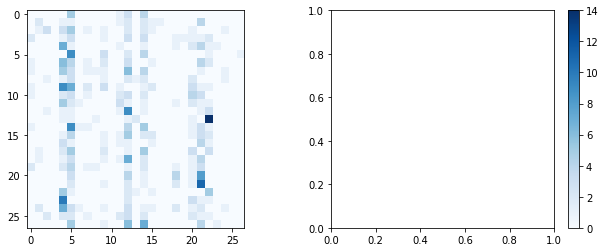

In [0]:
#En este bloque se importa el clasificador KNN, y se prosigue a realizar la clasificación con los dos grupos anteriores de
#entrenamiento y prueba, con los 10 vecinos más cercanos. Últimamente, para visualizar los resultados y su precisión, se imprime
#la matriz de confusión.

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

knn = KNeighborsClassifier(n_neighbors=21) #21 vecinos es lo mas óptimo
print(X.shape)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))



pred_train = knn.predict(X_train)
pred_test  = knn.predict(X_test)

cm_train_knn = confusion_matrix(y_train, pred_train)
cm_test_knn = confusion_matrix(y_test, pred_test)

plt.figure(figsize=(17,4))
plt.subplot(132),plt.imshow(cm_test_knn, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(133),plt.colorbar();

In [0]:
#En este bloque, por curiosidad de saber que número de vecinos da mejores resultados al aplicar KNN, se hizo una prueba con
#su cantidad variando desde 1 hasta 20.
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

neighbors = np.linspace(1,30,30)
accuracy = []
for i in log_progress(range(30), every = 1):
    neigh = KNeighborsClassifier(n_neighbors = i+1)
    neigh.fit(X_train, y_train)
    accuracy.append(neigh.score(X_test, y_test))
    print(accuracy[i])
plt.plot(neighbors, accuracy)

Dimensiones en Train (2023, 120000) (2023,)
Dimensiones en Test (675, 120000) (675,)
Precisión en Train 0.2031636183885319
Precisión en Test 0.13037037037037036


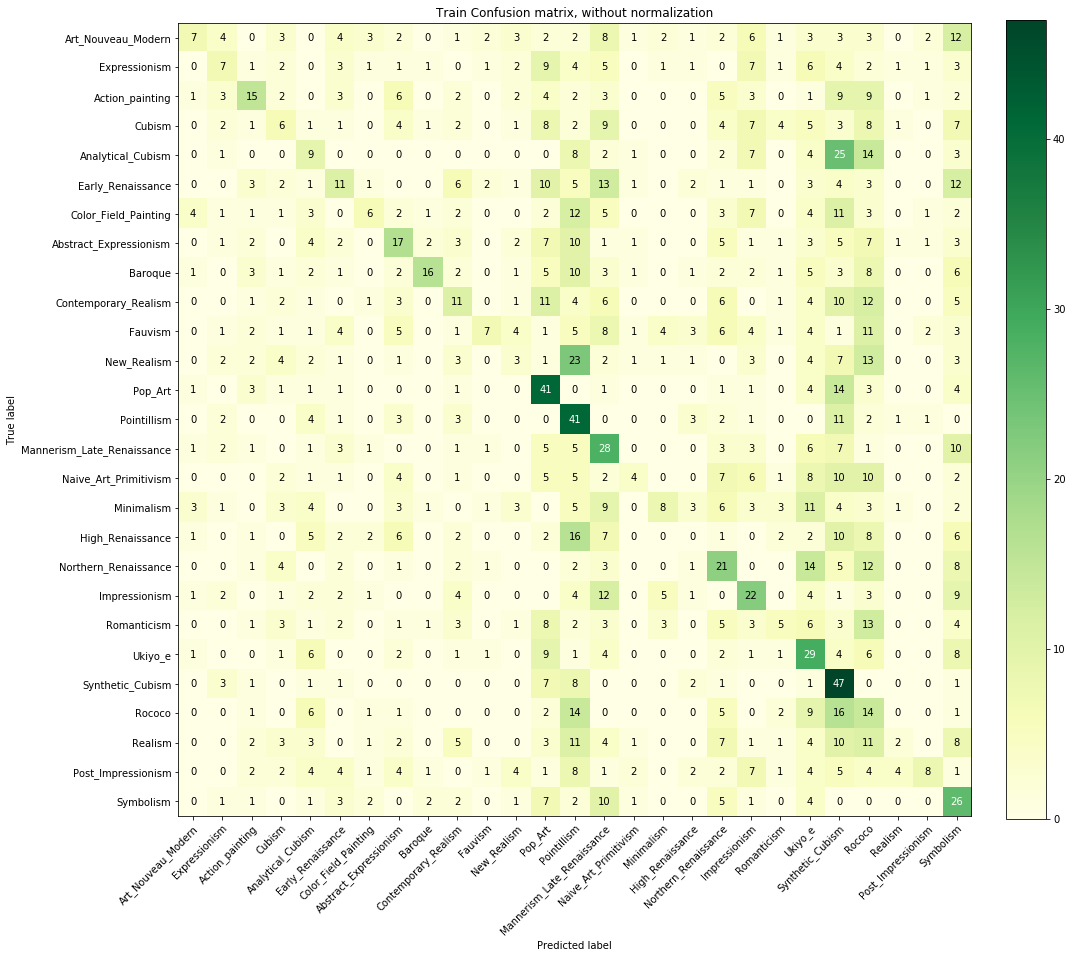

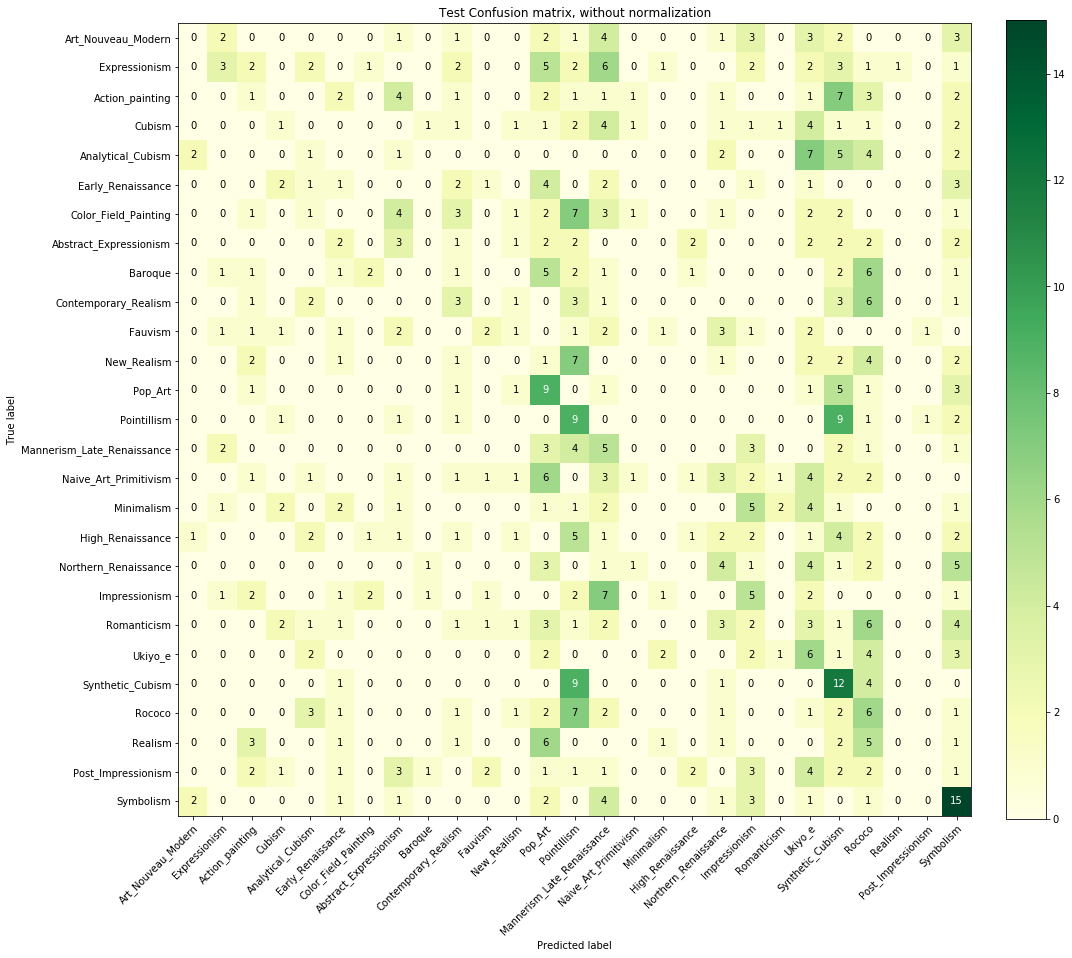

In [0]:
#Matrices de Confusión para Entrenamiento y Prueba (GaussianNB)

test_size = 0.25

d_train, d_test, c_train, c_test = train_test_split(X,y,test_size=test_size)

print("Dimensiones en Train", d_train.shape, c_train.shape)
print("Dimensiones en Test", d_test.shape, c_test.shape)

gnb = GaussianNB()
gnb.fit(d_train, c_train)
print("Precisión en Train", gnb.score(d_train, c_train))
print("Precisión en Test", gnb.score(d_test, c_test))

pred_train = gnb.predict(d_train)
pred_test  = gnb.predict(d_test)

cm_train = confusion_matrix(c_train, pred_train)
cm_test = confusion_matrix(c_test, pred_test)
print("Número de Imagenes por Clase en Test")
print(np.sum(cm_test, axis=1))

plt.figure(figsize=(17,4))
plt.subplot(141), plt.title('Matríz de Confusión en Train'), plt.imshow(cm_train, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(141), plt.colorbar();
plt.subplot(142), plt.title('Matríz de Confusión en Test'), plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(142), plt.colorbar();

Dimensiones en Train (2023, 120000) (2023,)
Dimensiones en Test (675, 120000) (675,)
Precisión en Train 0.9915966386554622
Precisión en Test 0.1985185185185185


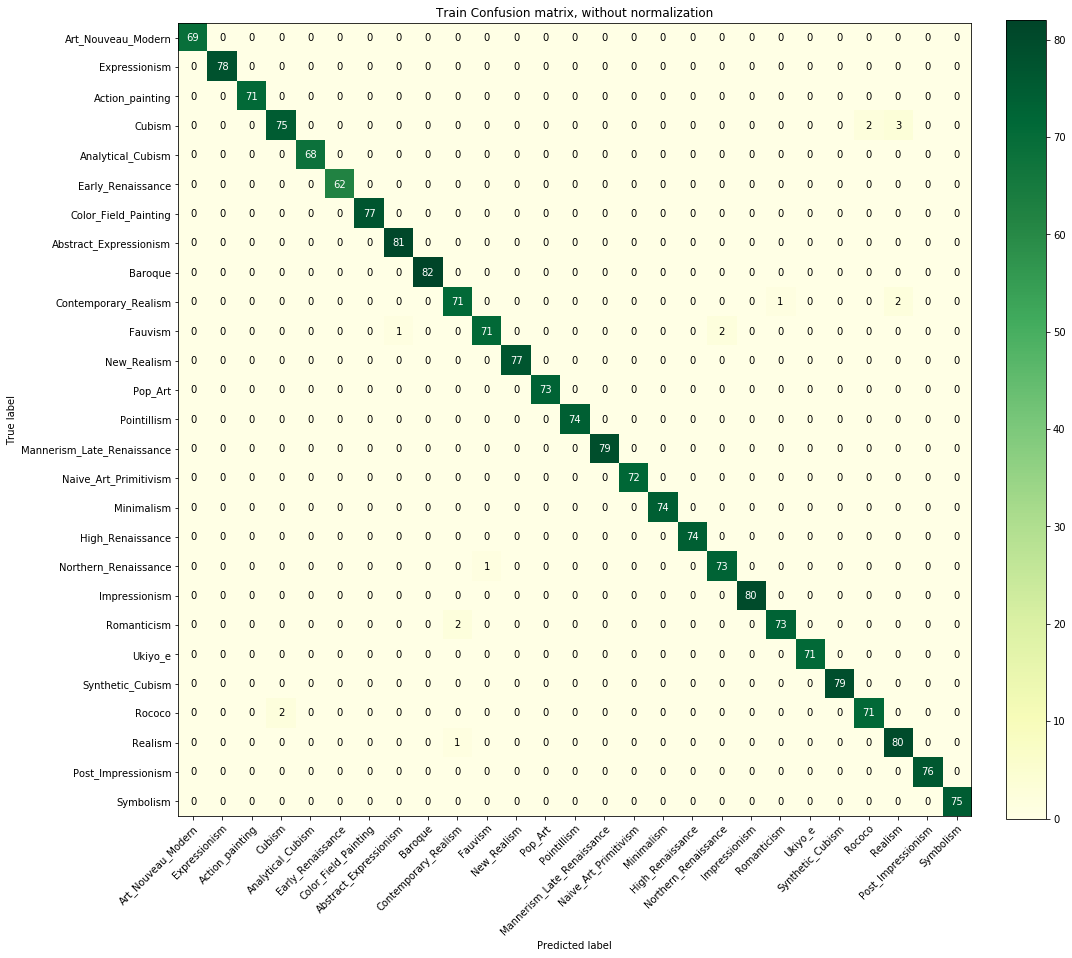

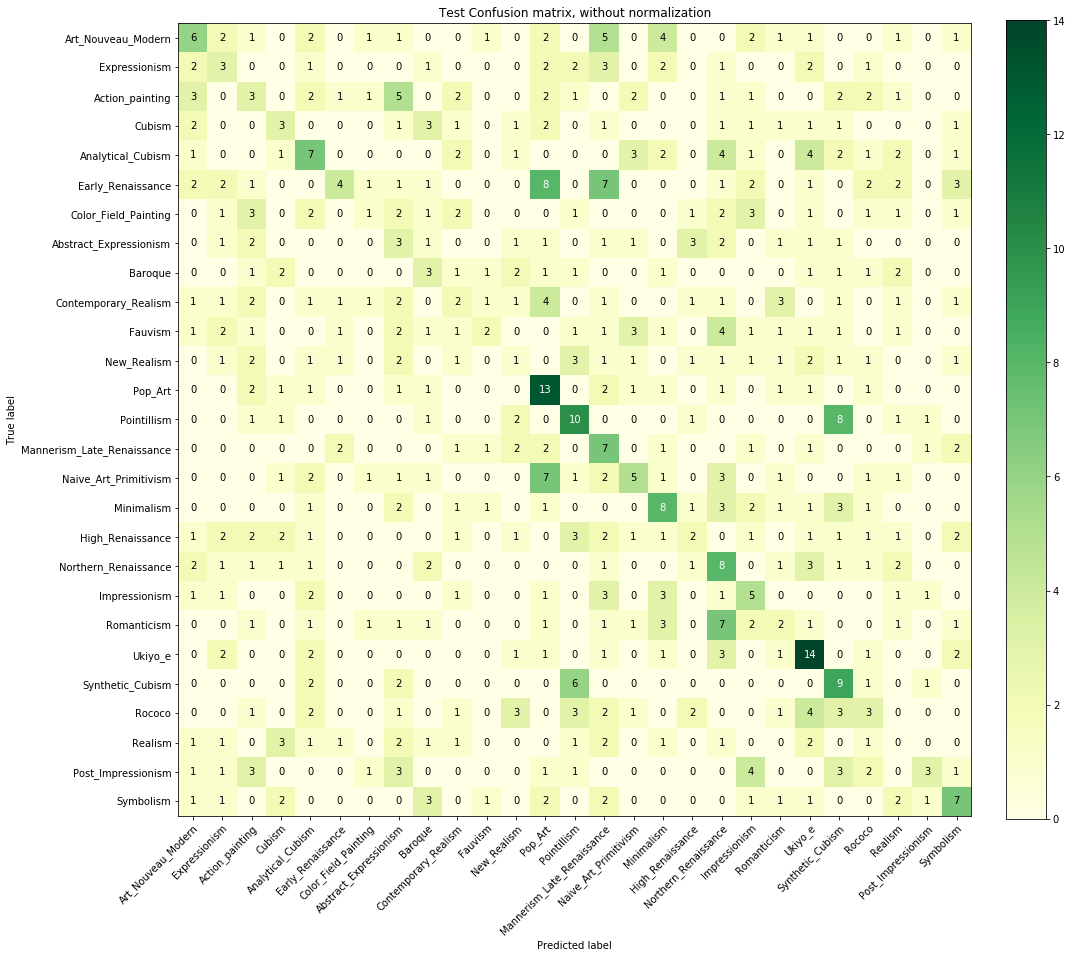

In [0]:
#Matrices de Confusión para Entrenamiento Y Prueba (RandomForestClassifier)

test_size = 0.25

d_train, d_test, c_train, c_test = train_test_split(X,y,test_size=test_size)

print("Dimensiones en Train", d_train.shape, c_train.shape)
print("Dimensiones en Test", d_test.shape, c_test.shape)

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(d_train, c_train)
print("Precisión en Train", rf.score(d_train, c_train))
print("Precisión en Test", rf.score(d_test, c_test))

pred_train = rf.predict(d_train)
pred_test  = rf.predict(d_test)

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true = c_train,
                      y_pred = pred_train,
                      classes = class_names,
                      title = 'Train Confusion matrix, without normalization',
                      normalize = False,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)

plot_confusion_matrix(y_true = c_test,
                      y_pred = pred_test,
                      classes = class_names,
                      title = 'Test Confusion matrix, without normalization',
                      normalize = False,
                      cmap = plt.cm.YlGn,
                      prnt_cm = False)
plt.show()

##Pipelines

In [0]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", RandomForestClassifier(n_estimators = 100)) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [0]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", GaussianNB()) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [0]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'poly', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [0]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'rbf', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [0]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'sigmoid', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [0]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'linear', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

###Componentes vs Precisión

In [0]:
n_components = range(100,1000,100)
means, stds = [], []

for n in n_components:
    print (n),
    p = Pipeline((("pca", PCA(n_components=n)), ("classifier", GaussianNB()) ))
    s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
    means.append(np.mean(s))
    stds.append(np.std(s))
means = np.r_[means]
stds  = np.r_[stds]

plt.plot(n_components, means, color="black")
plt.fill_between(n_components, means-stds, means+stds, color="blue", alpha=.5)
plt.xlabel("number of PCA componets")
plt.ylabel("accuracy")
plt.title("GaussianNB")

100


KeyboardInterrupt: ignored

In [0]:
n_components = range(100,1000,100)
means, stds = [], []

for n in n_components:
    print(n),
    p = Pipeline((("pca", PCA(n_components=n)), ("classifier", rf) ))
    s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
    means.append(np.mean(s))
    stds.append(np.std(s))
means = np.r_[means]
stds  = np.r_[stds]

plt.plot(n_components, means, color="black")
plt.fill_between(n_components, means-stds, means+stds, color="blue", alpha=.5)
plt.xlabel("number of PCA componets")
plt.ylabel("accuracy")
plt.title("RF")

100


KeyboardInterrupt: ignored

##GridSearch

In [0]:
trees = range(95, 106)
depth = range(95, 106)
criteria = ['gini', 'entropy']

dict_grid = dict(n_estimators = trees, criterion = criteria, max_depth = depth)

grid = GridSearchCV(rf, dict_grid, cv = 2, scoring = 'accuracy', return_train_score = False, n_jobs= -1)
grid.fit(d_test, c_test)

pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

print(grid.best_score_)
print(grid.best_params_)

#Clasificación con Key Points

##Extracción de Key Points y Descriptores con ORB

In [0]:
classes_names = os.listdir(path_classes)

array_imgs = []
array_imgs_classes = []
dic_imgs = {}

for i, name_class in enumerate(classes_names):
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i]))
    
for i, classes in enumerate(classes_names):
    for im_name in dic_imgs[classes]:
        path_image = classes+'/'+im_name
        array_imgs.append(path_image)
        array_imgs_classes.append(i)

img_dir_arr = np.r_[array_imgs]
img_class_dir_arr = np.r_[array_imgs_classes]

test_size = 0.2

img_dir_arr_train, img_dir_arr_test, y_train, y_test = train_test_split(img_dir_arr, img_class_dir_arr, test_size = test_size)

descriptor_extractor = ORB(n_keypoints=200, fast_threshold = 0.01)

array_ORB = np.empty([200,256])

for i in log_progress(range(len(img_dir_arr_train)), every = 1):
    stream = open(path_classes + img_dir_arr_train[i], "rb") #linea para opencv en windows, borrar en ubuntu
    bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
    img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
    img = cv.imdecode(img_array, 0) #linea para opencv en windows, borrar en ubuntu
    descriptor_extractor.detect_and_extract(img)
    descriptors1 = descriptor_extractor.descriptors
    array_ORB = np.vstack((array_ORB, descriptors1))

    
gc.collect()

print(array_ORB.shape)

In [0]:
v_words = 70
k = KMeans(n_clusters = v_words).fit(array_ORB)

In [0]:
visual_dictionary = k.cluster_centers_
print(visual_dictionary.shape)

In [0]:
arr_h_train = []
arr_h_test = []
ya_train = []
ya_test = []

dic_classes = {}
for index, name in enumerate(classes_names):
    dic_classes[name] = index+1
    
for i in log_progress((range(len(img_dir_arr_train))), every = 1):
    descriptor_extractor = ORB(n_keypoints=200, fast_threshold = 0.01)
    stream = open(path_classes + img_dir_arr_train[i], "rb") #linea para opencv en windows, borrar en ubuntu
    bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
    img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
    img = cv.imdecode(img_array, 0) #linea para opencv en windows, borrar en ubuntu
    descriptor_extractor.detect_and_extract(img)
    des_img = descriptor_extractor.descriptors
    h_img = build_histogram(des_img, k)
    arr_h_train.append(h_img)
    ya_train.append(os.path.basename(os.path.dirname(img_dir_arr_train[i])))

arr_h_train = np.r_[arr_h_train]
ya_train = np.r_[ya_train]
    
for i in log_progress((range(len(img_dir_arr_test))), every = 1):
    descriptor_extractor = ORB(n_keypoints=200, fast_threshold = 0.01)
    stream = open(path_classes + img_dir_arr_test[i], "rb") #linea para opencv en windows, borrar en ubuntu
    bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
    img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
    img = cv.imdecode(img_array, 0) #linea para opencv en windows, borrar en ubuntu
    descriptor_extractor.detect_and_extract(img)
    des_img = descriptor_extractor.descriptors
    h_img = build_histogram(des_img, k)
    arr_h_test.append(h_img)
    ya_test.append(os.path.basename(os.path.dirname(img_dir_arr_test[i])))
    
arr_h_test = np.r_[arr_h_test]
ya_test = np.r_[ya_test]

##Clasificación via Key Points

In [0]:
GN_est = GaussianNB()
RF_est = RandomForestClassifier(n_estimators=100, max_depth = 130)
SV_est = SVC(kernel='rbf', gamma = 'scale')
KN_est = KNeighborsClassifier(n_neighbors=10)

In [0]:
KN_est.fit(arr_h_train, ya_train)
KN_pr = KN_est.predict(arr_h_test)
print KN_est.score(arr_h_test, ya_test)
cm_test = confusion_matrix(ya_test, KN_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

In [0]:
GN_est.fit(arr_h_train, ya_train)
GN_pr = GN_est.predict(arr_h_test)
print GN_est.score(arr_h_test, ya_test)
cm_test = confusion_matrix(ya_test, GN_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

In [0]:
RF_est.fit(arr_h_train, ya_train)
RF_pr = RF_est.predict(arr_h_test)
print RF_est.score(arr_h_test, ya_test)
cm_test = confusion_matrix(ya_test, RF_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

In [0]:
SV_est.fit(arr_h_train, ya_train)
SV_pr = SV_est.predict(arr_h_test)
print SV_est.score(arr_h_test, ya_test)
cm_test = confusion_matrix(ya_test, SV_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();